In [835]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
import sys
import time
from scipy.stats import entropy
from math import log, e
from scipy.stats.stats import pearsonr  
from scipy.special import logit
from sklearn.linear_model import LogisticRegression
from scipy.stats import bernoulli, norm

plt.rc('axes', titlesize=20) 
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=20)

In [796]:
df_synthetic = pd.read_csv('synthetic_dataset_naive.csv', index_col=0)

In [798]:
# remove all observations where the grade value is NA, as they aren't useful to the regression analysis
df_synthetic_copy = df_synthetic.copy()
df_synthetic_copy = df_synthetic_copy[~pd.isnull(df_synthetic_copy.grade)]

In [799]:
df_synthetic_copy.shape

(11009668, 7)

In [801]:
# extract original dataset
df_original = df_synthetic_copy[df_synthetic_copy.grade != 9999]
nrows_original = len(df_original)

In [685]:
# df_synthetic_copy['grade'].fillna(0, inplace=True)

In [803]:
# calculate mean year of birth of observations in original dataset
mean_yob = round(np.mean(df_original.YoB))

In [804]:
# create indicator variable that is 1 if YoB is missing and 0 otherwise
df_synthetic_copy['YoB_missing'] = [int(pd.isnull(x)) for x in df_synthetic_copy.YoB]

In [805]:
# fill in missing YoB values with the mean YoB and center distribution of YoB at 0 to facilitate model fitting
df_synthetic_copy['YoB_centered'] = df_synthetic_copy['YoB']
df_synthetic_copy['YoB_centered'].fillna(mean_yob, inplace=True)
df_synthetic_copy['YoB_centered'] = df_synthetic_copy['YoB_centered'].apply(lambda x: x - mean_yob)

In [806]:
df_synthetic_copy.countryLabel.value_counts()

United States                     1967874
India                              466410
United Kingdom                     382869
Canada                             356540
Brazil                             343499
Australia                          239399
China                              234558
Mexico                             210179
Spain                              209843
Germany                            202835
France                             187697
Colombia                           154981
Netherlands                        140630
Greece                             131575
Italy                              124728
Japan                              121887
Turkey                             121321
Russian Federation                 121159
Singapore                          109625
Philippines                        109031
Hong Kong                          104534
Pakistan                            99622
Argentina                           98324
Peru                              

The output above shows that there are 254 unique countries whose residents have taken edX courses. Including every country as a different predictor in the model would make the training process extremely slow and would make it difficult for the model to identify the true effect of each country on grade (especially for those countries that have only a few students). Therefore, because the U.S. has almost 5 times the number of students as the next country (India), we decided to simply use an indicate variable that represents whether the student is from the U.S. or not. 

In [807]:
# add column that indicates whether a given student is from the United States or not
df_synthetic_copy['from_USA'] = [int(x == 'United States') for x in df_synthetic_copy.countryLabel]

In [808]:
# create new category for categorical variables that signifies that the original entry was missing
df_synthetic_copy.fillna('None', inplace=True)

In [809]:
df_synthetic_copy.head(20)

,course_id,YoB,countryLabel,LoE,gender,nforum_posts,grade,YoB_missing,YoB_centered,from_USA
95,HarvardX/PH525.1x/1T2018,None,Spain,None,None,0.0,1.00,1,0.0,0
196,HarvardX/PH525.1x/1T2018,None,United States,None,None,0.0,0.95,1,0.0,1
289,HarvardX/PH525.1x/1T2018,1980,Germany,b,m,0.0,1.00,0,-4.0,0
316,HarvardX/PH525.1x/1T2018,1969,Portugal,m,m,0.0,0.98,0,-15.0,0
346,HarvardX/PH525.1x/1T2018,1993,Spain,hs,m,0.0,0.96,0,9.0,0
698,HarvardX/PH525.1x/1T2018,1988,United States,b,f,0.0,0.70,0,4.0,1
773,HarvardX/PH525.1x/1T2018,1999,United States,jhs,m,0.0,0.71,0,15.0,1
877,HarvardX/PH525.1x/1T2018,None,New Zealand,None,None,0.0,0.71,1,0.0,0
1978,HarvardX/PH525.1x/1T2018,1983,Kenya,jhs,m,0.0,0.70,0,-1.0,0
2619,HarvardX/PH525.1x/1T2018,1976,United States,b,f,0.0,0.95,0,-8.0,1


In [810]:
# create copy of dataframe to prepare to train logistic regression model on observations that have grade of 0
df_log_reg = df_synthetic_copy.copy()

In [811]:
# add column that indicates whether observation has a grade of zero
df_log_reg['grade_zero'] = [int(x == 0) for x in df_log_reg.grade]

In [812]:
# create copy of dataframe to prepare to train GLM on observations that have non-zero grades
df_glm = df_log_reg.copy()

In [813]:
df_log_reg.columns

Index(['course_id', 'YoB', 'countryLabel', 'LoE', 'gender', 'nforum_posts',
       'grade', 'YoB_missing', 'YoB_centered', 'from_USA', 'grade_zero'],
      dtype='object')

In [814]:
# add indicator variables for each category for the following predictors: course_id, LoE and gender
df_log_reg_dummies = pd.get_dummies(df_log_reg, columns =['course_id', 'LoE', 'gender'])

In [815]:
# adding dummy variables produces an explosion in the number of predictors 
df_log_reg_dummies.shape

(11009668, 306)

In [816]:
# drop the following variables from design matrix: countryLabel, grade, grade_zero and YoB, and convert resulting
# dataframe into a numpy array. This array is the design matrix for the logistic regression model 
X = df_log_reg_dummies.drop(['countryLabel', 'grade', 'grade_zero', 'YoB'], axis=1).to_numpy()

In [817]:
# the indicator of whether the grade is zero is the response variable
y = np.array(df_log_reg['grade_zero'])

In [818]:
# train the model on the original dataset, and `test` the model on the synthetic observations
# (note: to be precise, we're not testing the model on the test set as there's no ground truth available; 
# instead, we're simply predicting the response variable on the test set)
X_train = X[:nrows_original, :]
X_test = X[nrows_original:, :]
y_train = y[:nrows_original]

In [940]:
print(f'fraction of observations in original dataset that have grade of 0: {round(np.mean(y_train), 3)}')

fraction of observations in original dataset that have grade of 0: 0.886


In [941]:
# fit logistic regression model without any regularization
log_reg_model = LogisticRegression(C=100000, solver='lbfgs', max_iter=3000)
log_reg_model.fit(X_train, y_train)

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=3000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [990]:
# predict probability of grade of 0 on test set
train_preds = log_reg_model.predict_proba(X_train)
prob_zero_grade_train = log_reg_preds[:, 1]

/Users/wfried/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


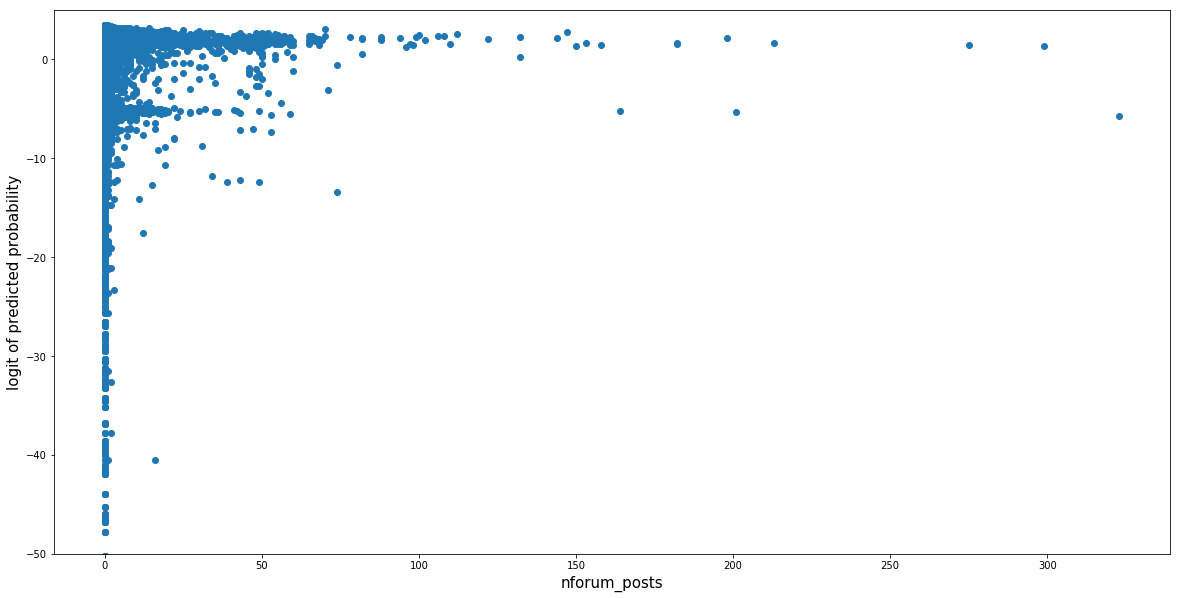

In [1047]:
plt.figure(figsize=(20, 10))
plt.scatter(X_train[:100000, 0], logit(prob_zero_grade_train[:100000]))
plt.xlabel('nforum_posts')
plt.ylabel('logit of predicted probability')
plt.ylim(-50, 5) 
plt.show()

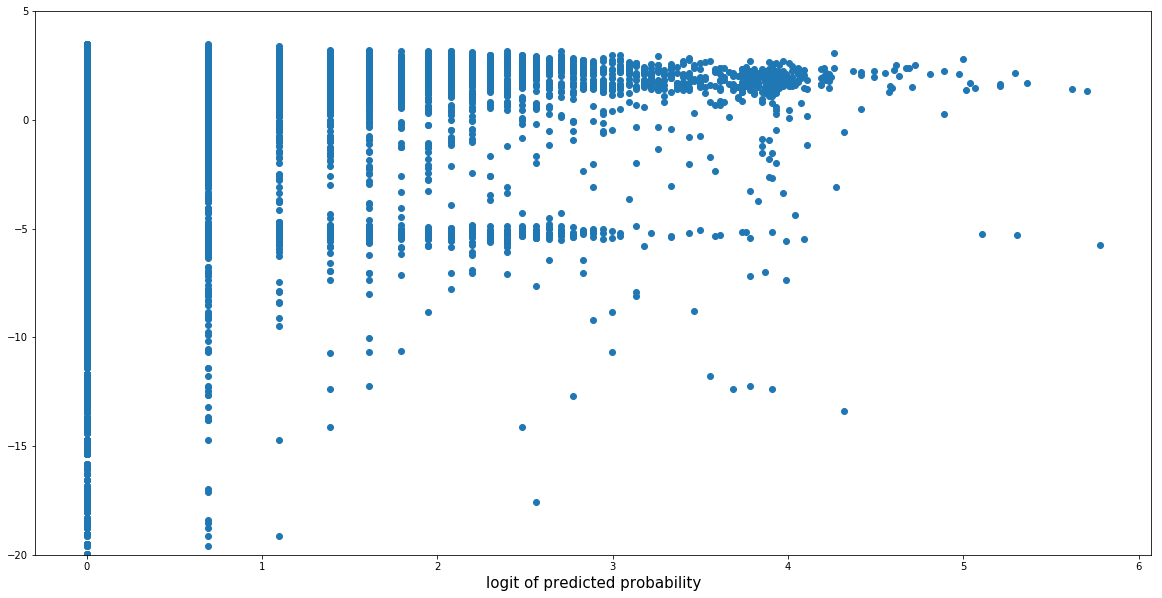

In [1007]:
plt.figure(figsize=(20, 10))
plt.scatter(np.log(X_train[:100000, 0] + 1), logit(prob_zero_grade_train[:100000]))
plt.xlabel('nforum_posts')
plt.ylabel('logit of predicted probability')
plt.ylim(-20, 5) 
plt.show()

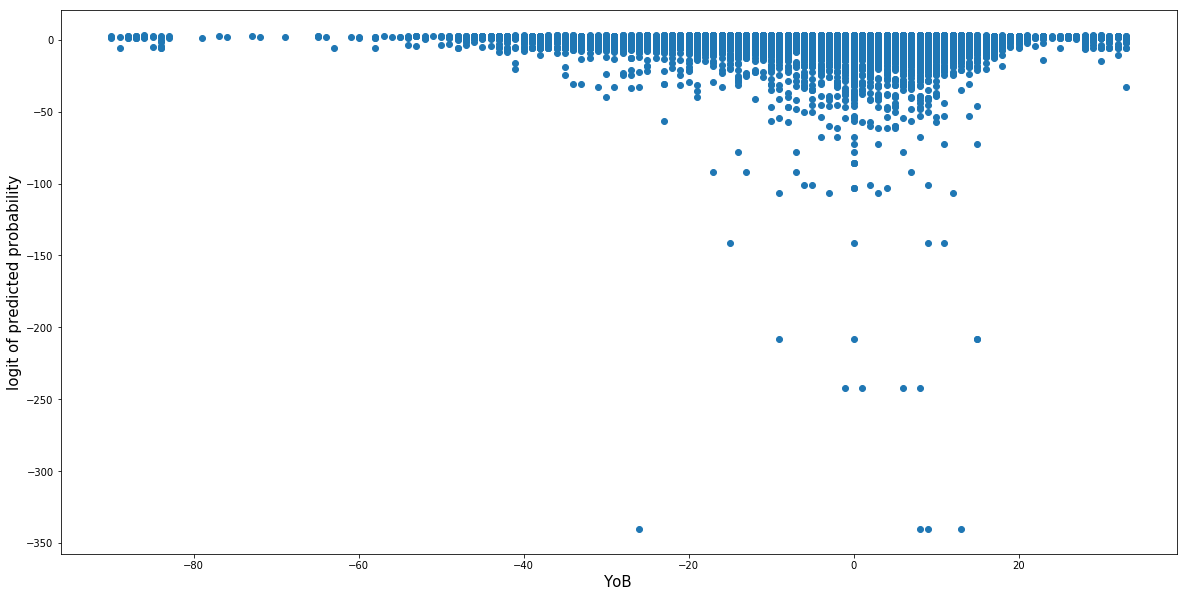

In [1016]:
plt.figure(figsize=(20, 10))
plt.scatter(X_train[:100000, 2], logit(prob_zero_grade_train[:100000]))
plt.xlabel('YoB')
plt.ylabel('logit of predicted probability')
plt.show()

In [1017]:
X_train_transformed = np.copy(X_train)
X_test_transformed = np.copy(X_test)
X_train_transformed[:, 0] = np.log(X_train_transformed[:, 0] + 1)
X_test_transformed[:, 0] = np.log(X_test_transformed[:, 0] + 1)

In [1021]:
# fit logistic regression model without any regularization
log_reg_transformed = LogisticRegression(C=100000, solver='lbfgs', max_iter=3000)
log_reg_transformed.fit(X_train_transformed, y_train)

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=3000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [1022]:
log_reg_preds_transformed = log_reg_transformed.predict_proba(X_test_transformed)
prob_zero_grade_transformed = log_reg_preds_transformed[:, 1]

In [988]:
# predict probability of grade of 0 on test set
log_reg_preds = log_reg_model.predict_proba(X_test)
prob_zero_grade = log_reg_preds[:, 1]

/Users/wfried/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [1048]:
# sample from resulting Bernoulli probability distribution for each observation in X_test
np.random.seed(221)
zero_grade_sample = bernoulli.rvs(p=prob_zero_grade_transformed)

In [1049]:
np.mean(prob_zero_grade_transformed)

0.7393490401045196

In [1050]:
# 
df_glm_original = df_glm.iloc[:nrows_original]
df_glm_added = df_glm.iloc[nrows_original:]

In [1051]:
# extract observations from original dataset where the grade value is not 0 or Null
df_glm_train = df_glm_original[(df_glm_original.grade != 0) & (df_glm_original.grade != 'None')]

/Users/wfried/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [1052]:
df_glm_train.drop(columns=['countryLabel', 'grade_zero', 'YoB'], inplace=True)

In [1053]:
# ensure that all non-zero grade values are between 0 and 1 (exclusive). This step is necessary because several
# of the grade values are negative, while several are equal to and greater than 1.0
df_glm_train['grade'] = df_glm_train['grade'].apply(lambda x: max(0.01, min(x, 0.999)))

/Users/wfried/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


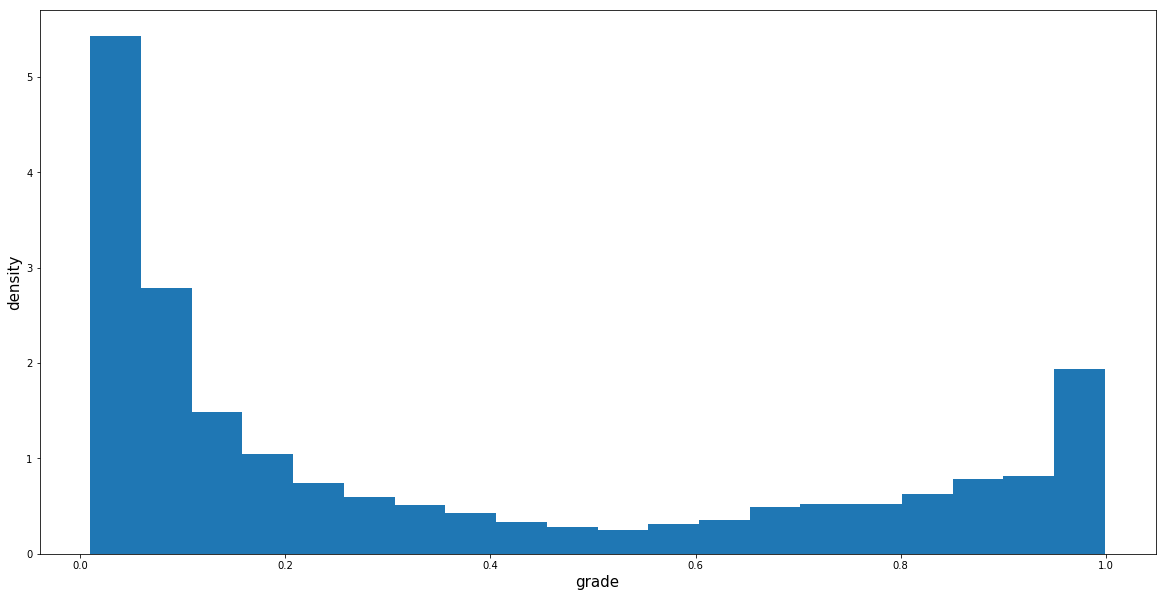

In [1054]:
# plot distribution of grade
plt.figure(figsize=(20, 10))
plt.hist(df_glm_train.grade, bins=20, density=True)
plt.xlabel('grade')
plt.ylabel('density')
plt.show()

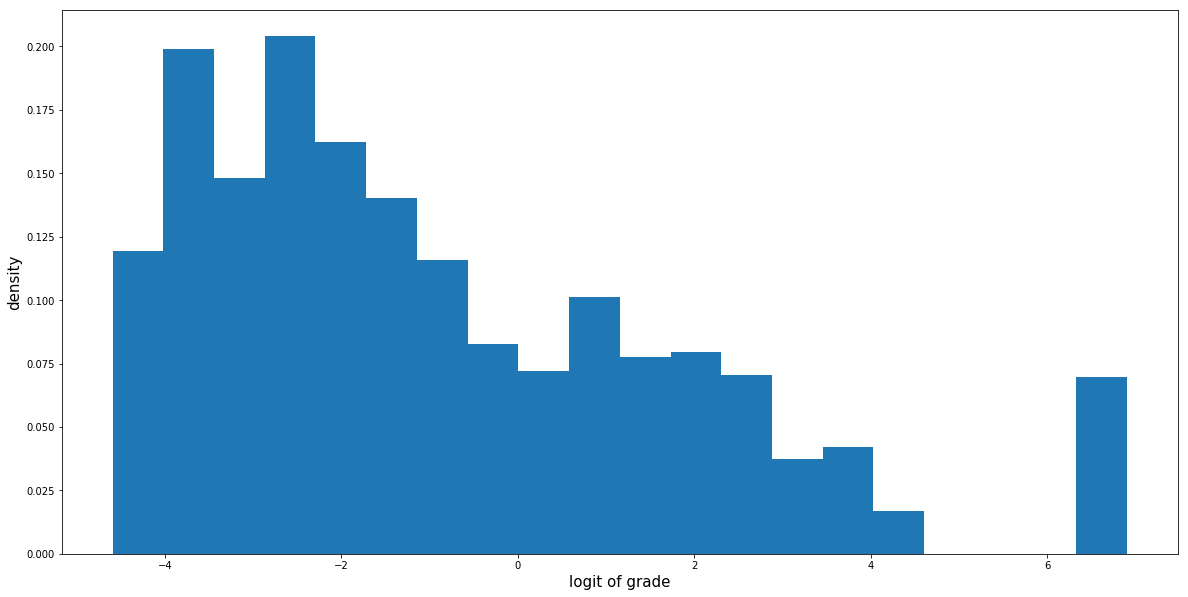

In [1055]:
plt.figure(figsize=(20, 10))
plt.hist(logit(df_glm_train.grade), bins=20, density=True)
plt.xlabel('logit of grade')
plt.ylabel('density')
plt.show()

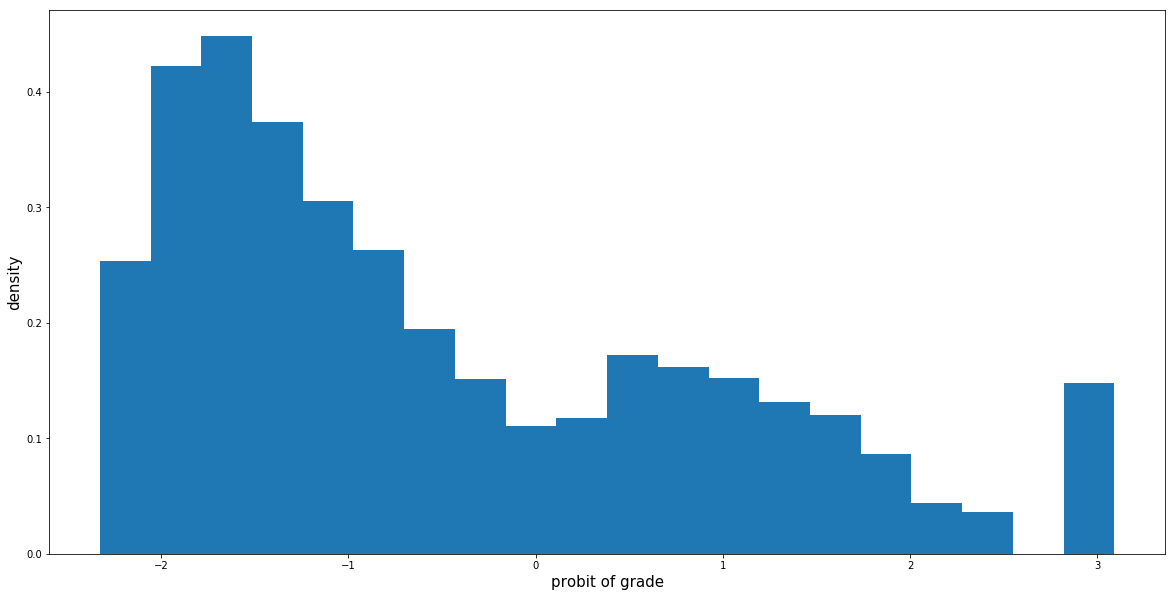

In [1056]:
# plot distribution of logit of grade
plt.figure(figsize=(20, 10))
plt.hist(norm.ppf(df_glm_train.grade), bins=20, density=True)
plt.xlabel('probit of grade')
plt.ylabel('density')
plt.show()

In [708]:
# convert training set to csv to transfer data to R
df_glm_train.to_csv('train_df.csv', index=False)

In [1026]:
df_glm_added.drop(columns=['countryLabel', 'grade_zero', 'YoB', 'grade'], inplace=True, errors='ignore')

/Users/wfried/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [1057]:
# add column that indicates whether grade is predicted to be zero
df_glm_added['is_grade_zero'] = zero_grade_sample

/Users/wfried/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1058]:
# only observations where grade is not predicted to be zero need to be processed
df_glm_test = df_glm_added[df_glm_added.is_grade_zero == 0]
df_glm_test.drop(columns=['is_grade_zero'], inplace=True)

In [1059]:
# convert test set to csv to transfer data to R
df_glm_test.to_csv('test_df.csv', index=False)

In [1064]:
# predict whether grade is zero for fake rows
df_fake = df_synthetic[df_synthetic.grade == 9999]
df_fake['grade'] = [0 if x == 1 else 9999 for x in zero_grade_sample]

/Users/wfried/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [1065]:
df_fake_predicted_zeros = df_fake[df_fake.grade == 0]
df_fake_predicted_not_zeros = df_fake[df_fake.grade != 0]

In [1061]:
# read in predictions of non-zero grades from R
predicted_grades_df = pd.read_csv('preds.csv')

In [1067]:
df_fake_predicted_not_zeros['grade'] = list(predicted_grades_df.preds)

/Users/wfried/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1069]:
# combine datasets to create final synthetic dataset
df_fake_grades_filled = pd.concat([df_fake_predicted_zeros, df_fake_predicted_not_zeros])
df_final = pd.concat([df_original, df_fake_grades_filled])

In [1071]:
# calculate mean and correlation in original dataset
mean_grade_original = np.mean(df_original.grade)
correlation_original = pearsonr(df_original.grade, df_original.nforum_posts)[0]

In [1072]:
# calculate mean and correlation in final synthetic dataset
mean_grade_final = np.mean(df_final.grade)
correlation_final = pearsonr(df_final.grade, df_final.nforum_posts)[0]

In [1073]:
print(f'mean bias: {abs(mean_grade_original - mean_grade_final)}')
print(f'correlation bias: {abs(correlation_original - correlation_final)}')

mean bias: 0.03723632698313643
correlation bias: 0.028509252228746812
